## 필요한 모듈 임포트

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

import time
from glob import glob
from tqdm import tqdm
from permetrics.regression import RegressionMetric

import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras import backend as K
from keras.utils import plot_model

from tensorflow.keras.layers import InputLayer

from keras.layers import Activation, Dense, LSTM, GRU, Bidirectional, AveragePooling1D, GlobalAveragePooling1D, Dropout, Flatten, BatchNormalization, TimeDistributed, Input, Reshape, RepeatVector, Concatenate, GlobalMaxPooling1D 
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D
from sklearn.metrics import r2_score

#GPU 자원이 부족
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## 데이터 불러오기, 정규화


In [ ]:
raw_data = pd.read_csv('', encoding = 'cp949')

# 사용할 컬럼: 방류량, 강화대교_조위, 청담대교_유량, 한강대교_유량, 행주대교_유량, 광진교_수위, 청담대교_수위, 잠수교_수위, 한강대교_수위, 행주대교_수위
raw_data = raw_data[['방류량', '강화대교_조위', '청담대교_유량', '한강대교_유량', '행주대교_유량', '광진교_수위', '청담대교_수위', '잠수교_수위', '한강대교_수위', '행주대교_수위']]

# 날짜를 index로 바꾸고 dtype을 datetime으로 바꾸기
raw_data.set_index(keys = ['날짜'], inplace = True)
raw_data.index = pd.to_datetime(raw_data.index, format = '%Y-%m-%d %H:%M')

# x y 나누기
input_y = raw_data[['청담대교_수위','잠수교_수위','한강대교_수위','행주대교_수위']]
input_x = raw_data

# 정규화
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

input_x_regular = input_x.copy()

for i in range(len(input_x.columns)):
    scaler = MinMaxScaler()
    a=np.array(input_x_regular.iloc[:,i])
    tmp_x = scaler.fit_transform(a.reshape(-1,1))
    input_x_regular.iloc[:,i] = tmp_x

input_regular = pd.concat([input_x_regular, input_y], axis = 1)
input_regular

,방류량,강화대교_조위,행주대교_유량,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위
날짜,,,,,,,,,,,
2012-05-01 00:00:00,0.058462,0.191781,0.011070,0.049611,0.060000,0.051621,0.056478,310.7,300.2,290.0,275.3
2012-05-01 00:10:00,0.058447,0.199253,0.011070,0.053502,0.060000,0.051621,0.056478,314.7,300.2,290.0,275.3
2012-05-01 00:20:00,0.057689,0.209215,0.011070,0.052529,0.061111,0.051621,0.056478,313.7,301.2,290.0,275.3
2012-05-01 00:30:00,0.058462,0.219178,0.011475,0.050584,0.061111,0.051621,0.058140,311.7,301.2,290.0,276.3
2012-05-01 00:40:00,0.058451,0.232877,0.011883,0.050584,0.061111,0.052821,0.059801,311.7,301.2,291.0,277.3
...,...,...,...,...,...,...,...,...,...,...,...
2022-07-18 23:10:00,0.046624,0.458281,0.025719,0.027529,0.054222,0.062425,0.107475,288.0,295.0,299.0,306.0
2022-07-18 23:20:00,0.046621,0.488169,0.026815,0.026556,0.063111,0.068427,0.110797,287.0,303.0,304.0,308.0
2022-07-18 23:30:00,0.046620,0.515567,0.027929,0.038230,0.067556,0.074430,0.114120,299.0,307.0,309.0,310.0


## train / test data 생성

In [1]:
# xdata, ydata: trainset + testset
# 이전 60분 동안의 방류량, 조위, 유량, 수위 데이터(x)로 현재 수위(y) 예측

xdata = []
ydata_cd = [] # 청담대교 ydata
ydata_js = [] # 잠수교 ydata
ydata_hg = [] # 한강대교 ydata
ydata_hj = [] # 행주대교 ydata

xdata_idx = range(len(input_x_regular))
ydata_idx = [-4,-3,-2,-1]

w =  6 # window size

# 같은 해의 데이터끼리 x, y 데이터셋을 이루도록 
# i.e. x가 2021년 10월 30일 23:00-23:50, y가 2022년 5월 1일 00:00가 되지 않도록 분리

idx = [] 
for i in range(12):
  idx.append(i*26496)

for i in tqdm(range(11)):
    if i != 10:
        tmp = input_regular[idx[i]:idx[i+1]]
    else:
        tmp = input_regular[idx[i]:]

    for j in range(len(tmp)-w):
        xdata.append(np.array(tmp.iloc[j:j + w, xdata_idx]).astype(float))

    for j in range(w,len(tmp)):
        ydata_cd.append(np.array(tmp.iloc[j, ydata_idx[1]]).astype(float))
        ydata_js.append(np.array(tmp.iloc[j, ydata_idx[2]]).astype(float))
        ydata_hg.append(np.array(tmp.iloc[j, ydata_idx[3]]).astype(float))
        ydata_hj.append(np.array(tmp.iloc[j, ydata_idx[4]]).astype(float))

NameError: ignored

In [ ]:
xdata_ = np.array(xdata)
ydata_cd_ = np.array(ydata_cd)
ydata_js_ = np.array(ydata_js)
ydata_hg_ = np.array(ydata_hg)
ydata_hj_ = np.array(ydata_hj)

xtrain = xdata_[:-6912]
ytrain_cd = ydata_cd[:-6912]
ytrain_js = ydata_js[:-6912]
ytrain_hg = ydata_hg[:-6912]
ytrain_hj = ydata_hj[:-6912]

xtest = xdata_[-6912:]
ytest_cd = ydata_cd[-6912:]
ytest_js = ydata_js[-6912:]
ytest_hg = ydata_hg[-6912:]
ytest_hj = ydata_hj[-6912:]

In [ ]:
print(xtrain.shape)
print(ytrain_cd.shape)
print(xtest.shape)
print(ytest_cd.shape)

(269358, 6, 7)
(269358, 4)
(6912, 6, 7)
(6912, 4)


## 모델 정의, 학습

### 공통

In [ ]:
epochs = 100
batch_size = xtrain.shape[0] // 1000
validation = 0.4

checkpoint_callback = ModelCheckpoint(filepath='best_model.h5', save_weights_only=False, monitor='val_loss',
                                         mode='min', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10, mode='min')
rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode='min', patience=3, min_lr=1e-10)

### 청담대교

In [2]:
# model_cd: model for 청담대교 (from 청담대교_1.45)

def nse(y_true, y_pred):
    return (1-(K.sum((y_true-y_pred)**2)/K.sum((y_true-K.mean(y_true))**2)))

def root_mean_squared_error(y_true, y_pred):
    return (K.sqrt(K.mean(K.square(y_pred - y_true))))

if 'model_cd' in locals(): 
    del model_cd 
if 'history_cd' in locals():
    del history_cd

optimizer = tf.keras.optimizers.Adam(lr=0.01) #기본값 0.001

model_cd = Sequential()
model_cd.add(InputLayer(input_shape=(w, xtrain.shape[2])))
model_cd.add(Conv1D(filters=64, kernel_size=2, padding = 'causal', activation='relu'))
model_cd.add(Flatten())

model_cd.add(RepeatVector(1))
model_cd.add(GRU(200, activation='relu', return_sequences=True))
model_cd.add(GRU(200, activation='relu', return_sequences=True))
model_cd.add(GRU(200, activation='relu'))

model_cd.add(Dense(100, activation='relu'))
model_cd.add(Dense(1))

model_cd.compile(loss=root_mean_squared_error, optimizer=optimizer, metrics =[nse])

model_cd.summary()

NameError: ignored

In [ ]:
# 학습
history_cd = model_cd.fit(xtrain, ytrain_cd, verbose=1, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])

In [ ]:
# 평가
keras_model_best_cd = keras.models.load_model('best_model.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error, 'nse': nse})
yhat_cd = keras_model_best_cd.predict(xtest, verbose=1)
keras_model_best_cd.evaluate(xtest,ytest_cd)

In [ ]:
# 학습 과정 시각화
fig, loss_ax = plt.subplots(1, 2)
fig.set_size_inches((15,5))

loss_ax[0].plot(history_cd.history['loss'], 'b', label='train loss')
loss_ax[0].plot(history_cd.history['val_loss'], 'r', label='val loss')

loss_ax[1].plot(history_cd.history['nse'], 'y', label='train nse')
loss_ax[1].plot(history_cd.history['val_nse'], 'g', label='val nse')

loss_ax[0].set_xlabel('epoch')
loss_ax[0].set_ylabel('loss')
loss_ax[1].set_xlabel('epoch')
loss_ax[1].set_ylabel('nse')

loss_ax[0].legend(loc='upper right')
loss_ax[1].legend(loc='lower right')

plt.show()

### 잠수교

In [ ]:
# model_js: model for 잠수교 (from 잠수교_0.9)

if 'model_js' in locals(): 
    del model_js 
if 'history_js' in locals():
    del history_js

optimizer = tf.keras.optimizers.Adam(lr=0.01) #기본값 0.001

model_js = Sequential()
model_js.add(Conv1D(filters=64, kernel_size=2, padding = 'causal', activation='relu', input_shape=(w, xtrain.shape[2])))
model_js.add(Flatten())

model_js.add(RepeatVector(1))
model_js.add(LSTM(200, activation='relu', return_sequences=True))
model_js.add(BatchNormalization(momentum=0.99, scale=False, center=False))
model_js.add(LSTM(200, activation='relu', return_sequences=True))
model_js.add(LSTM(200, activation='relu', return_sequences=True))
model_js.add(LSTM(200, activation='relu'))

model_js.add(Dense(100, activation='relu'))
model_js.add(Dense(1))

model_js.compile(loss=root_mean_squared_error, optimizer=optimizer, metrics =[nse])

model_js.summary()

In [ ]:
# 학습
history_js = model_js.fit(xtrain, ytrain_js, verbose=1, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])

In [ ]:
# 평가
keras_model_best_js = keras.models.load_model('best_model.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error, 'nse': nse})
yhat_js = keras_model_best_js.predict(xtest, verbose=1)
keras_model_best_js.evaluate(xtest,ytest_js)

In [ ]:
# 학습 과정 시각화
fig, loss_ax = plt.subplots(1, 2)
fig.set_size_inches((15,5))

loss_ax[0].plot(history_js.history['loss'], 'b', label='train loss')
loss_ax[0].plot(history_js.history['val_loss'], 'r', label='val loss')

loss_ax[1].plot(history_js.history['nse'], 'y', label='train nse')
loss_ax[1].plot(history_js.history['val_nse'], 'g', label='val nse')

loss_ax[0].set_xlabel('epoch')
loss_ax[0].set_ylabel('loss')
loss_ax[1].set_xlabel('epoch')
loss_ax[1].set_ylabel('nse')

loss_ax[0].legend(loc='upper right')
loss_ax[1].legend(loc='lower right')

plt.show()

### 한강대교

In [1]:
# model_hg: model for 한강대교 (from 한강대교_1.1)

if 'model_hg' in locals(): 
    del model_hg 
if 'history_hg' in locals():
    del history_hg

optimizer = tf.keras.optimizers.Adam(lr=0.01) #기본값 0.001

model_hg = Sequential()
model_hg.add(InputLayer(input_shape=(w, xtrain.shape[2])))
model_hg.add(Conv1D(filters=64, kernel_size=2, padding = 'causal', activation='relu'))
model_hg.add(Flatten())

model_hg.add(RepeatVector(1))
model_hg.add(LSTM(200, activation='relu', return_sequences=True))
model_hg.add(LSTM(200, activation='relu', return_sequences=True))
model_hg.add(LSTM(200, activation='relu'))

model_hg.add(Dense(100, activation='relu'))
model_hg.add(Dense(1))

model_hg.compile(loss=root_mean_squared_error, optimizer=optimizer, metrics =[nse])

model_hg.summary()

NameError: ignored

In [ ]:
# 학습
history_hg = model_js.fit(xtrain, ytrain_hg, verbose=1, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])

In [ ]:
# 평가
keras_model_best_hg = keras.models.load_model('best_model.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error, 'nse': nse})
yhat_hg = keras_model_best_hg.predict(xtest, verbose=1)
keras_model_best_hg.evaluate(xtest,ytest_hg)

In [ ]:
# 학습 과정 시각화
fig, loss_ax = plt.subplots(1, 2)
fig.set_size_inches((15,5))

loss_ax[0].plot(history_hg.history['loss'], 'b', label='train loss')
loss_ax[0].plot(history_hg.history['val_loss'], 'r', label='val loss')

loss_ax[1].plot(history_hg.history['nse'], 'y', label='train nse')
loss_ax[1].plot(history_hg.history['val_nse'], 'g', label='val nse')

loss_ax[0].set_xlabel('epoch')
loss_ax[0].set_ylabel('loss')
loss_ax[1].set_xlabel('epoch')
loss_ax[1].set_ylabel('nse')

loss_ax[0].legend(loc='upper right')
loss_ax[1].legend(loc='lower right')

plt.show()

### 행주대교

In [ ]:
# model_hj: model for 행주대교 (from 행주대교_1.21)

if 'model_hj' in locals(): 
    del model_hj 
if 'history_hj' in locals():
    del history_hj

optimizer = tf.keras.optimizers.Adam(lr=0.01) #기본값 0.001

model_hj = Sequential()
model_hj.add(InputLayer(input_shape=(w, xtrain.shape[2])))
model_hj.add(Conv1D(filters=64, kernel_size=2, padding = 'causal', activation='relu'))
model_hj.add(Flatten())

model_hj.add(RepeatVector(1))
model_hj.add(LSTM(200, activation='relu', return_sequences=True))
model_hj.add(LSTM(200, activation='relu', return_sequences=True))
model_hj.add(LSTM(200, activation='relu'))

model_hj.add(Dense(100, activation='relu'))
model_hj.add(Dense(1))

model_hj.compile(loss=root_mean_squared_error, optimizer=optimizer, metrics =[nse])

model_hj.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 64)             960       
                                                                 
 flatten (Flatten)           (None, 384)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 1, 384)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 1, 200)            468000    
                                                                 
 lstm_1 (LSTM)               (None, 1, 200)            320800    
                                                                 
 lstm_2 (LSTM)               (None, 200)               320800    
                                                        

In [ ]:
history_hj = model_hg.fit(xtrain, ytrain_hj, verbose=1, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])

In [ ]:
keras_model_best_hj = keras.models.load_model('best_model.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error, 'nse': nse})

yhat_hj = keras_model_best_hj.predict(xtest, verbose=1)

keras_model_best_hj.evaluate(xtest,ytest_hj)

216/216 [==============================] - 1s 2ms/step - loss: 1.1931 - nse: 0.9894


[1.1931111812591553, 0.9894020557403564]

In [ ]:
fig, loss_ax = plt.subplots(1, 2)
fig.set_size_inches((15,5))

loss_ax[0].plot(history_hj.history['loss'], 'b', label='train loss')
loss_ax[0].plot(history_hj.history['val_loss'], 'r', label='val loss')

loss_ax[1].plot(history_hj.history['nse'], 'y', label='train nse')
loss_ax[1].plot(history_hj.history['val_nse'], 'g', label='val nse')

loss_ax[0].set_xlabel('epoch')
loss_ax[0].set_ylabel('loss')
loss_ax[1].set_xlabel('epoch')
loss_ax[1].set_ylabel('nse')

loss_ax[0].legend(loc='upper right')
loss_ax[1].legend(loc='lower right')

plt.show()

## 학습 과정 시각화

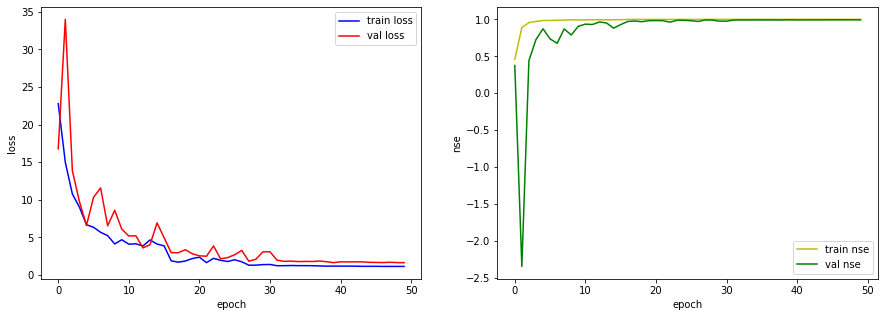

In [ ]:
fig, loss_ax = plt.subplots(1, 2)
fig.set_size_inches((15,5))

loss_ax[0].plot(history.history['loss'], 'b', label='train loss')
loss_ax[0].plot(history.history['val_loss'], 'r', label='val loss')

loss_ax[1].plot(history.history['nse'], 'y', label='train nse')
loss_ax[1].plot(history.history['val_nse'], 'g', label='val nse')

loss_ax[0].set_xlabel('epoch')
loss_ax[0].set_ylabel('loss')
loss_ax[1].set_xlabel('epoch')
loss_ax[1].set_ylabel('nse')

loss_ax[0].legend(loc='upper right')
loss_ax[1].legend(loc='lower right')

plt.show()

## 결과 시각화

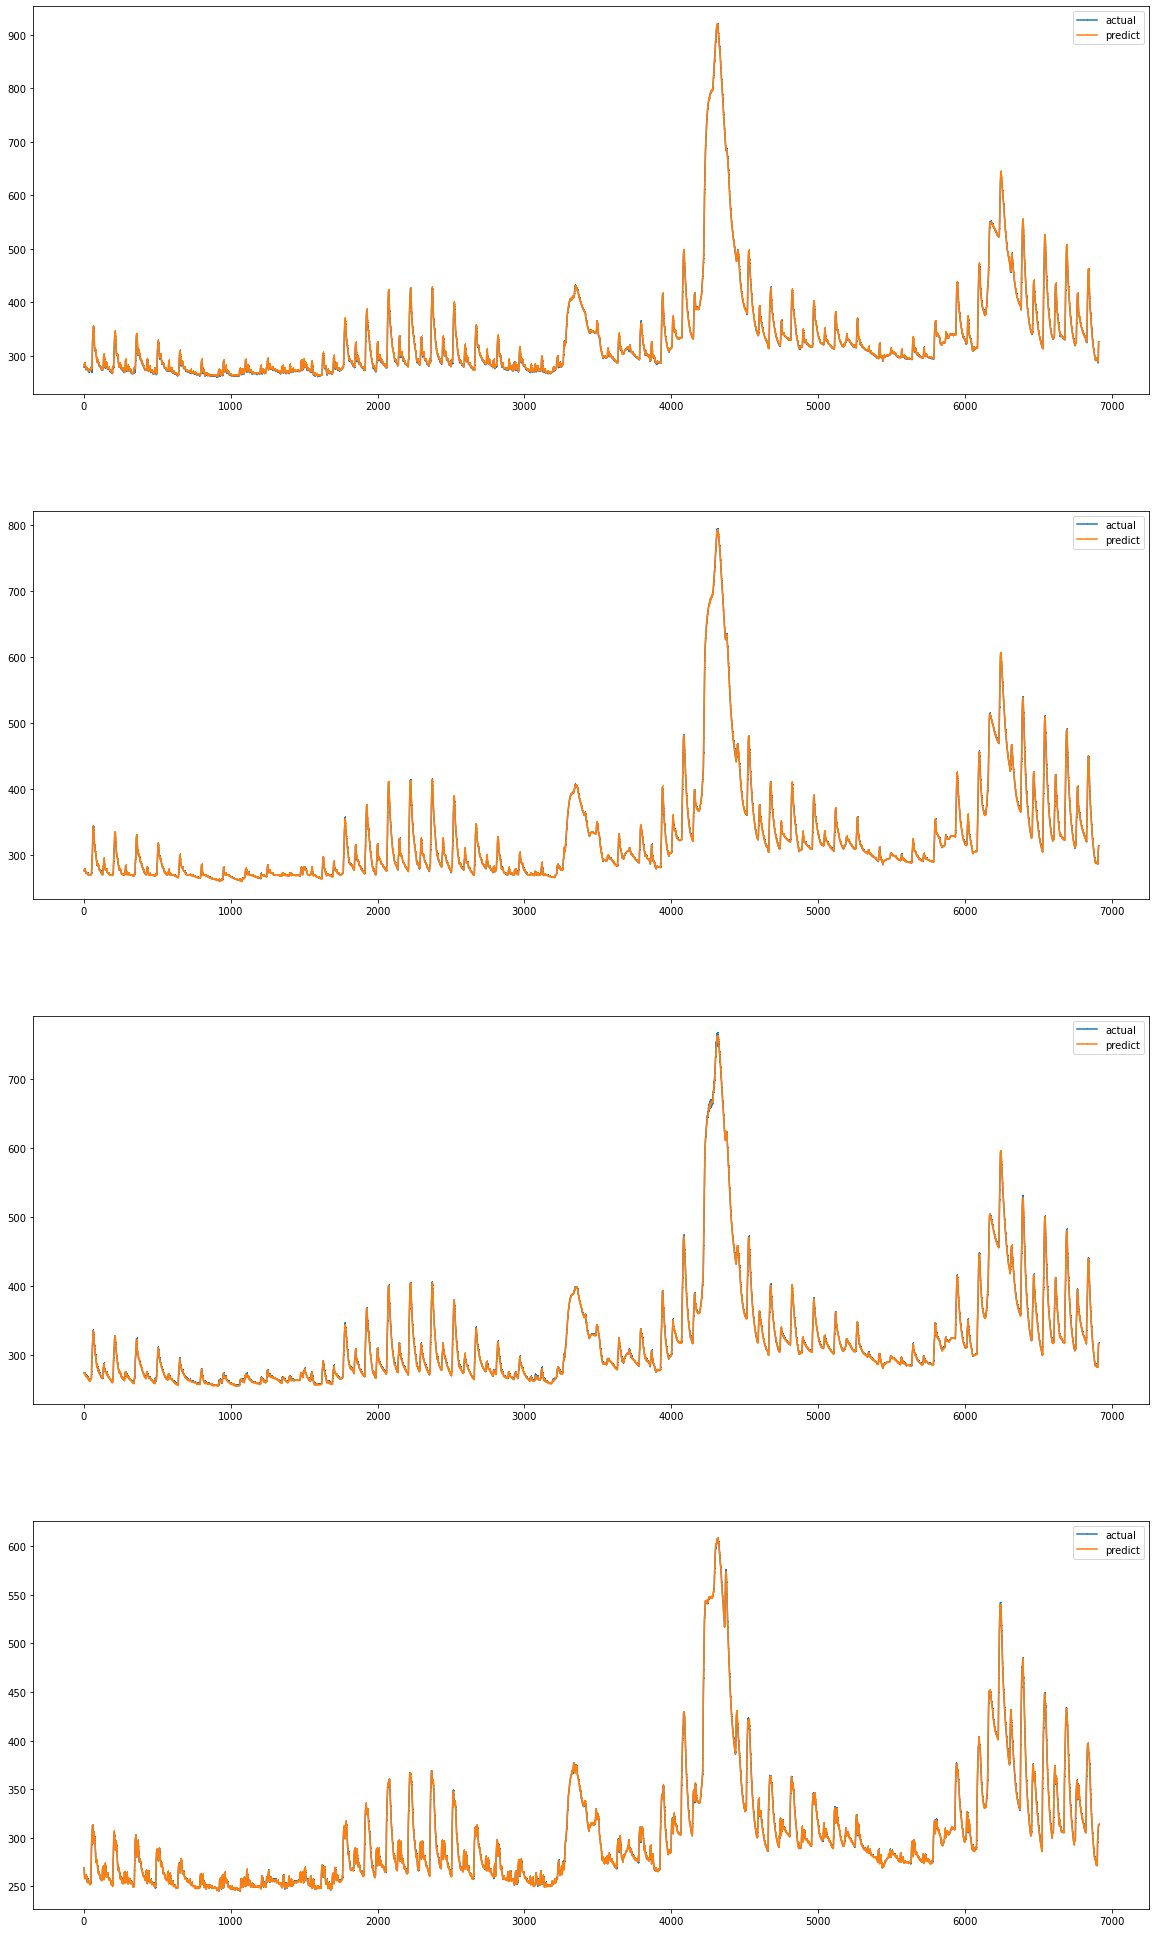

In [ ]:
cd_predict = np.array(yhat_cd).T
js_predict = np.array(yhat_js).T
hg_predict = np.array(yhat_hg).T
hj_predict = np.array(yhat_hj).T

#결과 시각화
f, axes = plt.subplots(4, 1)
f.set_size_inches((20, 35))
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

axes[0].plot(ytest_cd, marker = ",", label = "actual")
axes[0].plot(cd_predict, marker = ",", label="predict")
axes[0].legend(prop={'size':10})  

axes[1].plot(ytest_js, marker = ",", label = "actual")
axes[1].plot(js_predict, marker = ",", label="predict")
axes[1].legend(prop={'size':10})  

axes[2].plot(ytest_hg, marker = ",", label = "actual")
axes[2].plot(hg_predict, marker = ",", label="predict")
axes[2].legend(prop={'size':10})  

axes[3].plot(ytest_hj, marker = ",", label = "actual")
axes[3].plot(hj_predict, marker = ",", label="predict")
axes[3].legend(prop={'size':10})  

plt.show()

## 점수 확인

In [ ]:
score = []

print(root_mean_squared_error(ytest_cd, cd_predict)  / r2_score(ytest_cd, cd_predict))
score.append(root_mean_squared_error(ytest_cd, cd_predict) / r2_score(ytest_cd, cd_predict))

print(root_mean_squared_error(ytest_js, js_predict)  / r2_score(ytest_js, js_predict))
score.append(root_mean_squared_error(ytest_js, js_predict) / r2_score(ytest_js, js_predict))

print(root_mean_squared_error(ytest_hg, hg_predict)  / r2_score(ytest_hg, hg_predict))
score.append(root_mean_squared_error(ytest_hg, hg_predict) / r2_score(ytest_hg, hg_predict))

print(root_mean_squared_error(ytest_hj, hj_predict)  / r2_score(ytest_hj, hj_predict))
score.append(root_mean_squared_error(ytest_hj, hj_predict) / r2_score(ytest_hj, hj_predict))
    
print("최종점수: ", np.mean(score))

tf.Tensor(1.6551855293455724, shape=(), dtype=float64)
tf.Tensor(0.8969054744540481, shape=(), dtype=float64)
tf.Tensor(1.2343622624745005, shape=(), dtype=float64)
tf.Tensor(1.2149060095552375, shape=(), dtype=float64)
최종점수:  1.2503398189573396


## 파일 제출

In [ ]:
sample_submission = pd.read_csv("/content/drive/MyDrive/신입기수 프로젝트/DACON/competition_data/sample_submission.csv")

sample_submission["wl_1018662"] = cd_predict
sample_submission["wl_1018680"] = js_predict
sample_submission["wl_1018683"] = hg_predict
sample_submission["wl_1019630"] = hj_predict

sample_submission.to_csv("/content/drive/MyDrive/신입기수 프로젝트/제출용 코드 정리/최종파일.csv", index = False)